# Analysis of experimentally measured beam loss

The beam loss at injection shall be compared to the theoretical expectation. 

Let $I_F$ be the intensity of the beam at time $T_F$ the end of INJECTION (beginning of PREPARE RAMP) and $\Delta I_i$ the intensity injected at the injection step $i$. The time of injection at the step $i$ is denoted as $T_i$. Assuming that all losses are caused by dynamic aperture, the final intensity is related to the injected intensity as 

$$ I_F = 2 \, \sum_{i=0}^N \, \Delta I_i \, \int_{D(T_F-T_i)}^{\infty} \rho(x) \, dx \, ,$$

where $\rho(x)$ is the transverse particle distribution, $D(T_F-T_i)$ is the dynamic aperture for the injected bunch at the end of INJECTION and $N$ is the number of injection steps. We are interested in relative losses, so we are going to compare the quantity

$$ r = \frac{\sum_i^N \Delta I_i - I_F}{\sum_i^N \Delta I_i} \, .$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytimber as pt
import time

import sixdesk.dist as dist

In [2]:
class davsturn:
    def __init__(self):
        self.revf = 11245.5                                 # LHC revolution frequency        
        pass
    
    def _get_turn_from_time(self,time):
        '''returns the number of turns from the circulation time in seconds'''
        return self.revf*60*60*time        
    
    def davst_function(self,time,d,b,k):
        '''returns the DA as a function of time for a given set of function parameters'''
        turn = self._get_turn_from_time(time)
        return d + (b/(np.log10(turn)**k))  
    
    def davst_range(self,time,params):
        '''Returns the minimum, maximum and mean DA for the given time with a set of parameters'''
        data = self.davst_function(time,params['d'],params['b'],params['k'])
        return data.min(),data.mean(),data.max()
    
    def get_beam_loss(self,time,params):
        '''returns a range for the beam loss from the da distribution'''
        data = self.davst_range(time,params)
        import sixdesk.dist as dist

        avgloss = dist.get_loss_from_da(data[1],which='mean')
        maxloss = dist.get_loss_from_da(data[0],which='max')        
        minloss = dist.get_loss_from_da(data[2],which='min')
        
        return minloss,avgloss,maxloss

In [3]:
hdf    = pd.HDFStore("da_results.h5")
params = hdf['lhc_b1_inj_exdafunc_qp_20_ioct_40']
params = hdf['lhc_b2_inj_exdafunc_qp_20_ioct_40']

fills  = pd.read_csv('fills_2016.csv',usecols=[0],names=['fill'],skiprows=1) # all fills in 2016 in stable beams
fills  = np.array(fills['fill'])

## Load the database and find variables if needed

In [4]:
db = pt.LoggingDB()

In [10]:
db.search("%OCTUP%")

[]

In [487]:
db.getDescription('LHC.BOFSU:CHROMA_B1_H')

{u'LHC.BOFSU:CHROMA_B1_H': u'Beam 1 horizontal chromaticity'}

In [5]:
b1intensity = 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'
b2intensity = 'LHC.BCTDC.B6R4.B2:BEAM_INTENSITY'
lhc_energy  = 'LHC.BQSH.B1:ENERGY'
beam_mode   = 'LHC.CISG.CCR.A:BEAM_MODE'
chroma      = 'LHC.BOFSU:CHROMA_B1_H'

In [6]:
def get_injection_phases(fill_number):
    data = db.getLHCFillData(fill_number)['beamModes']
    for j in data:
        if j['mode']=='INJPHYS':
            return j['startTime'], j['endTime']

In [7]:
def _get_raw_injection_times(dataset,thresh=0.005e14):    
    time_array, intensity_array = dataset
    indices = np.diff(intensity_array)>thresh
    indices = np.append(indices, False)
    return time_array[indices], intensity_array[indices]

def get_injection_times(dataset, thresh=0.005e14):
    injection_times, injection_intensity = _get_raw_injection_times(dataset,thresh=thresh)
    
    steps_indices   = np.diff(injection_times)>2.      # use only steps which are more than 2 seconds apart from another
    steps_indices   = np.append(steps_indices, True)
    
    injection_intensity = injection_intensity[steps_indices]
    injection_times     = injection_times[steps_indices]
    return injection_times, injection_intensity


def get_delta_i(dataset):
    time_steps, intensity_steps    = get_injection_times(dataset)
    time_injection, data_injection = dataset
    output = []
    for n in range(len(time_steps)):
        int_before_step = data_injection[time_injection <= time_steps[n]+5]
        output.append([time_steps[n], intensity_steps[n], int_before_step[-1] - int_before_step[-10]])
    return pd.DataFrame(output,columns=['time','intensity_before_injection','injected_intensity'])

def get_experimental_beam_loss(dataset):
    injected_beam = get_delta_i(dataset)
    times_to_eoi  = get_time_to_prepare_ramp(dataset)
    
    return (injected_beam['injected_intensity'].sum()-dataset[1][-1])/injected_beam['injected_intensity'].sum()

def get_time_to_prepare_ramp(dataset):
    return dataset[0][-1] - get_delta_i(dataset)['time']
    
    
def get_theoretical_loss(dataset):

    d     = davsturn()
    times = get_time_to_prepare_ramp(dataset)
    steps = get_delta_i(dataset)['injected_intensity']

    output = []
    for i in range(len(times)):
        ddd = d.get_beam_loss(times[i],params)
        ddd = 1-np.array(ddd)
        a, b, c = ddd
        output.append([steps[i],a,b,c])
    output = pd.DataFrame(output,columns=['step','min','mean','max'])
    
    minloss = (output['step'].sum()-(output['step']*output['min']).sum())/(output['step'].sum())
    maxloss = (output['step'].sum()-(output['step']*output['max']).sum())/(output['step'].sum())
    avgloss = (output['step'].sum()-(output['step']*output['mean']).sum())/(output['step'].sum())    
    return minloss, avgloss, maxloss

## Analyze the past runs 
### Beam 1

In [8]:
params = hdf['lhc_b1_inj_exdafunc_qp_20_ioct_40']

output =[]
for fill in fills:
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        tmin, tavg,tmax = get_theoretical_loss(data[b1intensity])
        output.append([fill,experimental,tmin,tavg,tmax])
    except IndexError:
        pass
output = pd.DataFrame(output,columns=['fill','experimental','tmin','tavg','tmax'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [9]:
output=output[(output['experimental']>0) & (output['experimental']<0.05)]

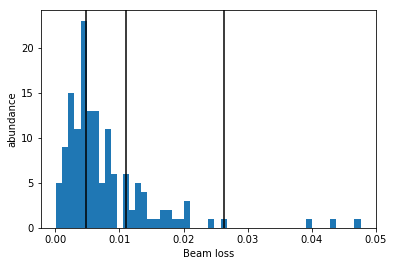

In [10]:
plt.hist(output['experimental'],bins=50)
plt.axvline(0.0048,0,100,color='k')
plt.axvline(0.011,0,100,color='k')
plt.axvline(0.02635,0,100,color='k')
plt.xlabel("Beam loss")
plt.ylabel("abundance")
plt.show()

In [11]:
perc = []
for i in np.arange(0,100,0.1):
    perc.append([i,np.percentile(output['experimental'],i)])
perc = pd.DataFrame(perc,columns=['perc','quant'])

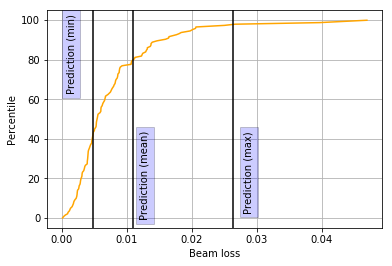

In [16]:
plt.plot(perc['quant'], perc['perc'],'-',color='orange')
plt.axvline(0.0048,0,100,color='k')
plt.axvline(0.011,0,100,color='k')
plt.axvline(0.0264,0,100,color='k')
plt.grid()
plt.ylabel('Percentile')
plt.xlabel('Beam loss')
plt.text(0.0007,99,"Prediction (min)",rotation=90, bbox=dict(facecolor='blue', alpha=0.2))
plt.text(0.012,40,"Prediction (mean)",rotation=90, bbox=dict(facecolor='blue', alpha=0.2))
plt.text(0.028,40,"Prediction (max)",rotation=90, bbox=dict(facecolor='blue', alpha=0.2))

# plt.xlim(0,0.01)
plt.show()

In [24]:
perc[(perc['quant']>0.0048) & (perc['quant']<0.0264)]['perc'].describe()

count    562.00000
mean      69.65000
std       16.23797
min       41.60000
25%       55.62500
50%       69.65000
75%       83.67500
max       97.70000
Name: perc, dtype: float64

56.1% of the data are inside the boundaries of the prediction

### Beam 2

In [12]:
params = hdf['lhc_b2_inj_exdafunc_qp_20_ioct_40']

output =[]
for fill in fills:
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b2intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b2intensity])
        tmin, tavg,tmax = get_theoretical_loss(data[b2intensity])
        output.append([fill,experimental,tmin,tavg,tmax])
    except IndexError:
        pass
output = pd.DataFrame(output,columns=['fill','experimental','tmin','tavg','tmax'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [14]:
output=output[(output['experimental']>0) & (output['experimental']<0.05)]

In [17]:
output.head()

,fill,experimental,tmin,tavg,tmax
0,5451,0.003505,0.000509,0.001789,0.008567
1,5450,0.003909,0.000509,0.001788,0.008530
2,5448,0.005585,0.000509,0.001790,0.008643
3,5446,0.001015,0.000509,0.001786,0.008445
4,5443,0.002801,0.000509,0.001791,0.008709


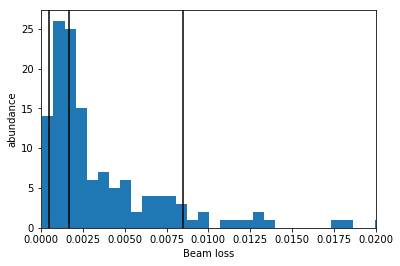

In [39]:
plt.hist(output['experimental'],bins=60)
plt.axvline(0.0005,0,100,color='k')
plt.axvline(0.0017,0,100,color='k')
plt.axvline(0.0085,0,100,color='k')
plt.xlabel("Beam loss")
plt.ylabel("abundance")
plt.xlim(0,0.02)

plt.show()

In [19]:
output.describe()

,fill,experimental,tmin,tavg,tmax
count,135.000000,135.000000,1.350000e+02,135.000000,135.000000
mean,5175.718519,0.004183,5.087246e-04,0.001790,0.008631
std,156.667089,0.005521,1.315193e-08,0.000001,0.000074
min,4895.000000,0.000086,5.086886e-04,0.001786,0.008445
25%,5054.000000,0.001164,5.087139e-04,0.001789,0.008573
50%,5169.000000,0.002128,5.087237e-04,0.001790,0.008617
75%,5276.500000,0.004993,5.087343e-04,0.001791,0.008680
max,5451.000000,0.039869,5.087686e-04,0.001795,0.008944


In [31]:
perc = []
for i in np.arange(0,100,0.1):
    perc.append([i,np.percentile(output['experimental'],i)])
perc = pd.DataFrame(perc,columns=['perc','quant'])

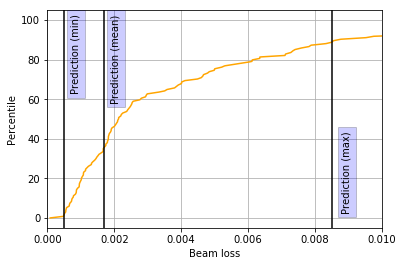

In [75]:
plt.plot(perc['quant'], perc['perc'],'-',color='orange')
plt.axvline(0.0005,0,100,color='k')
plt.axvline(0.0017,0,100,color='k')
plt.axvline(0.0085,0,100,color='k')
plt.grid()
plt.ylabel('Percentile')
plt.xlabel('Beam loss')
plt.text(0.0007,99,"Prediction (min)",rotation=90, bbox=dict(facecolor='blue', alpha=0.2))
plt.text(0.0019,99,"Prediction (mean)",rotation=90, bbox=dict(facecolor='blue', alpha=0.2))
plt.text(0.0088,40,"Prediction (max)",rotation=90, bbox=dict(facecolor='blue', alpha=0.2))

plt.xlim(0,0.01)
plt.show()

90.5% of the values are inside the limits of the prediction.